## Imports

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import pickle
import joblib

In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix,\
                             explained_variance_score, mean_squared_error, max_error, mean_absolute_error,\
                             root_mean_squared_error, median_absolute_error
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA, KernelPCA
# pas besoin de feature selection parce que pas beacoup de colonnes

import optuna

In [3]:
import read_mist_models

from utils import Iso_data_handler

def gaussian(dsts):
    kernel_width = .5
    weights = np.exp(-(dsts**2)/kernel_width)
    return weights

# To find certain rows

def isclose_pandas_apply(row, col_name, value, bool_index, rel_tol=1e-6):
    if math.isclose(row[col_name], value, rel_tol=rel_tol):
        bool_index.append(True)
    else:
        bool_index.append(False)

def isclose_pandas(df, col_name, value, rel_tol=1e-6):
    bool_index = []
    df.apply(isclose_pandas_apply, axis=1, args=(col_name, value, bool_index, rel_tol))
    return bool_index

## Data preparation

In [4]:
iso_handler = Iso_data_handler("C:/Users/antoi/Code/unif/MA2/Thèse/data/MIST_v1.2_vvcrit0.0_basic_isos/", 
                              ['log10_isochrone_age_yr', 'log_Teff', 'log_g', 'star_mass', 'phase', 'metallicity', 'log_R'])


In [5]:
iso_df = iso_handler.full_iso_data_to_panda()

Reading dataframe from csv file...


In [6]:
display(iso_df)

,log10_isochrone_age_yr,log_Teff,log_g,star_mass,phase,metallicity,log_R
0,5.0,3.486221,3.131342,0.100000,-1.0,-0.25,0.153402
1,5.0,3.487362,3.126808,0.102645,-1.0,-0.25,0.160326
2,5.0,3.489243,3.119367,0.107039,-1.0,-0.25,0.171785
3,5.0,3.491102,3.112165,0.111419,-1.0,-0.25,0.183099
4,5.0,3.492937,3.105143,0.115789,-1.0,-0.25,0.194305
...,...,...,...,...,...,...,...
1467117,10.3,4.402490,7.777159,0.532726,6.0,0.50,-1.806255
1467118,10.3,4.387132,7.783242,0.532730,6.0,0.50,-1.809295
1467119,10.3,4.371789,7.789130,0.532735,6.0,0.50,-1.812237
1467120,10.3,4.356480,7.794844,0.532741,6.0,0.50,-1.815091


In [7]:
# Keeping only the relevant star phases
phase_filtered_iso_df = iso_df\
    .where((iso_df.phase == 0) | (iso_df.phase == 2) | (iso_df.phase == 3) | (iso_df.phase == 4) | (iso_df.phase == 5))\
    .dropna().reset_index(drop=True)

In [ ]:
display(phase_filtered_iso_df)

,log10_isochrone_age_yr,log_Teff,log_g,star_mass,phase,metallicity,log_R
0,5.0,4.494412,4.346972,13.584360,0.0,-0.25,0.610679
1,5.0,4.497517,4.345776,13.765512,0.0,-0.25,0.614753
2,5.0,4.500556,4.344580,13.942887,0.0,-0.25,0.618755
3,5.0,4.504040,4.343050,14.591712,0.0,-0.25,0.624670
4,5.0,4.507576,4.341483,15.426062,0.0,-0.25,0.631187
...,...,...,...,...,...,...,...
1165292,10.3,3.425746,-0.551440,0.602856,5.0,0.50,2.384899
1165293,10.3,3.426469,-0.560350,0.598549,5.0,0.50,2.387797
1165294,10.3,3.427744,-0.566057,0.594116,5.0,0.50,2.389036
1165295,10.3,3.429413,-0.569225,0.589648,5.0,0.50,2.388981


In [ ]:
X = phase_filtered_iso_df.drop(['star_mass', 'phase', 'log_R'], axis=1).to_numpy()
y = phase_filtered_iso_df[['star_mass', 'log_R']].to_numpy()

X_TRAIN, X_IVS, y_TRAIN, y_IVS = train_test_split(X, y, test_size=0.25, random_state=1337)

print(X_TRAIN.shape, X_IVS.shape)
print(y_TRAIN.shape, y_IVS.shape)

(873972, 4) (291325, 4)
(873972, 2) (291325, 2)


In [10]:
print(f"Range in train data for the mass parameter : {min(y_TRAIN[:, 0])} - {max(y_TRAIN[:, 0])}")
print(f"Median value in train data for the mass parameter: {np.median(y_TRAIN[:, 0])}")
print(f"Mean value in train data for the mass parameter: {np.mean(y_TRAIN[:, 0])}")

print(f"Range in test data for the mass parameter : {min(y_IVS[:, 0])} - {max(y_IVS[:, 0])}")
print(f"Median value in test data for the mass parameter: {np.median(y_IVS[:, 0])}")
print(f"Mean value in test data for the mass parameter: {np.mean(y_IVS[:, 0])}")

print()

print(f"Range in train data for the radius parameter : {min(y_TRAIN[:, 1])} - {max(y_TRAIN[:, 1])}")
print(f"Median value in train data for the radius parameter: {np.median(y_TRAIN[:, 1])}")
print(f"Mean value in train data for the radius parameter: {np.mean(y_TRAIN[:, 1])}")

print(f"Range in test data for the radius parameter : {min(y_IVS[:, 1])} - {max(y_IVS[:, 1])}")
print(f"Median value in test data for the radius parameter: {np.median(y_IVS[:, 1])}")
print(f"Mean value in test data for the radius parameter: {np.mean(y_IVS[:, 1])}")


Range in train data for the mass parameter : 0.0999979840073621 - 296.5221171165397
Median value in train data for the mass parameter: 2.0298876569807147
Mean value in train data for the mass parameter: 7.387582424532589
Range in test data for the mass parameter : 0.099998052173157 - 298.5447575808816
Median value in test data for the mass parameter: 2.031987247312461
Mean value in test data for the mass parameter: 7.403392070038953

Range in train data for the radius parameter : -2.085171571669866 - 3.1297545143214007
Median value in train data for the radius parameter: 1.4613315181026039
Mean value in train data for the radius parameter: 1.3545468932779332
Range in test data for the radius parameter : -2.081830985668411 - 3.129269620812593
Median value in test data for the radius parameter: 1.457489869624725
Mean value in test data for the radius parameter: 1.353692007577153


In [11]:
phase_mass_filtered_iso_df = phase_filtered_iso_df.where(phase_filtered_iso_df.star_mass < 30)\
                                                  .dropna()\
                                                  .reset_index(drop=True)

In [12]:
display(phase_mass_filtered_iso_df)

,log10_isochrone_age_yr,log_Teff,log_g,star_mass,phase,metallicity,log_R
0,5.0,4.494412,4.346972,13.584360,0.0,-0.25,0.610679
1,5.0,4.497517,4.345776,13.765512,0.0,-0.25,0.614753
2,5.0,4.500556,4.344580,13.942887,0.0,-0.25,0.618755
3,5.0,4.504040,4.343050,14.591712,0.0,-0.25,0.624670
4,5.0,4.507576,4.341483,15.426062,0.0,-0.25,0.631187
...,...,...,...,...,...,...,...
1105728,10.3,3.425746,-0.551440,0.602856,5.0,0.50,2.384899
1105729,10.3,3.426469,-0.560350,0.598549,5.0,0.50,2.387797
1105730,10.3,3.427744,-0.566057,0.594116,5.0,0.50,2.389036
1105731,10.3,3.429413,-0.569225,0.589648,5.0,0.50,2.388981


In [13]:
X_mass = phase_mass_filtered_iso_df.drop(['star_mass', 'phase', 'log_R'], axis=1).to_numpy()
y_mass = phase_mass_filtered_iso_df[['star_mass', 'log_R']].to_numpy()

X_TRAIN_mass, X_IVS_mass, y_TRAIN_mass, y_IVS_mass = train_test_split(X_mass, y_mass, test_size=0.25, random_state=1337)

print(X_TRAIN_mass.shape, X_IVS_mass.shape)
print(y_TRAIN_mass.shape, y_IVS_mass.shape)

(829299, 4) (276434, 4)
(829299, 2) (276434, 2)


In [14]:
print(f"Range in train data for the mass parameter : {min(y_TRAIN_mass[:, 0])} - {max(y_TRAIN_mass[:, 0])}")
print(f"Median value in train data for the mass parameter: {np.median(y_TRAIN_mass[:, 0])}")
print(f"Mean value in train data for the mass parameter: {np.mean(y_TRAIN_mass[:, 0])}")

print(f"Range in test data for the mass parameter : {min(y_IVS_mass[:, 0])} - {max(y_IVS_mass[:, 0])}")
print(f"Median value in test data for the mass parameter: {np.median(y_IVS_mass[:, 0])}")
print(f"Mean value in test data for the mass parameter: {np.mean(y_IVS_mass[:, 0])}")

print()

print(f"Range in train data for the radius parameter : {min(y_TRAIN_mass[:, 1])} - {max(y_TRAIN_mass[:, 1])}")
print(f"Median value in train data for the radius parameter: {np.median(y_TRAIN_mass[:, 1])}")
print(f"Mean value in train data for the radius parameter: {np.mean(y_TRAIN_mass[:, 1])}")

print(f"Range in test data for the radius parameter : {min(y_IVS_mass[:, 1])} - {max(y_IVS_mass[:, 1])}")
print(f"Median value in test data for the radius parameter: {np.median(y_IVS_mass[:, 1])}")
print(f"Mean value in test data for the radius parameter: {np.mean(y_IVS_mass[:, 1])}")


Range in train data for the mass parameter : 0.0999979840073621 - 29.999136881366123
Median value in train data for the mass parameter: 1.9047225616504784
Mean value in train data for the mass parameter: 3.779408465788556
Range in test data for the mass parameter : 0.099998052173157 - 29.99765995263001
Median value in test data for the mass parameter: 1.9113123276427197
Mean value in test data for the mass parameter: 3.7827566056407123

Range in train data for the radius parameter : -2.085171571669866 - 3.1297545143214007
Median value in train data for the radius parameter: 1.4586781496654344
Mean value in train data for the radius parameter: 1.343133819049337
Range in test data for the radius parameter : -2.0797611943433547 - 3.1252095788165946
Median value in test data for the radius parameter: 1.471910293946708
Mean value in test data for the radius parameter: 1.3479451503057525


## PCA data preparation

In [15]:
pca = PCA(n_components=4) # maybe try with less or more components
pca.fit(X_TRAIN)
tve=0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()

PC0 - Variance explained:  0.5934 - Total Variance:  0.5934
PC1 - Variance explained:  0.2337 - Total Variance:  0.8271
PC2 - Variance explained:  0.1685 - Total Variance:  0.9955
PC3 - Variance explained:  0.0045 - Total Variance:  1.0000



In [16]:
X_TRAIN_PCA=pca.transform(X_TRAIN)
X_IVS_PCA=pca.transform(X_IVS)
print(X_TRAIN_PCA.shape)

(873972, 4)


## Model training

In [ ]:

# TODO faire que la fonction puisse accepter autant d'output qu'on veut
# TODO mettre les outputs du modèle dans un fichier csv pour utiliser plus tard
# TODO mettre la possibilité de rajouter des paramètres à tester dans le modèle
# TODO rajouter le calcul du temps et le rajouter dans le csv

def Kfold_pipeline(model, x_train_data=X_TRAIN, y_train_data=y_TRAIN, filename="", n_splits=10, shuffle=True):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=12)
    TRUTH_MASS=None
    TRUTH_RADIUS=None
    PREDS_MASS=None
    PREDS_RADIUS=None
    counter = 0
    print("split", end=' ')
    for train_index, test_index in kf.split(x_train_data):
        counter += 1
        print(str(counter), end=' ')
        X_train, X_test = x_train_data[train_index], x_train_data[test_index]
        y_train, y_test = y_train_data[train_index], y_train_data[test_index]

        mdl = model()
        mdl.fit(X_train, y_train)
        preds = mdl.predict(X_test)

        if TRUTH_MASS is None:
            PREDS_MASS=preds[:, 0]
            TRUTH_MASS=y_test[:, 0]
        else:
            PREDS_MASS=np.hstack((PREDS_MASS, preds[:, 0]))
            TRUTH_MASS=np.hstack((TRUTH_MASS, y_test[:, 0]))

        if TRUTH_RADIUS is None:
            PREDS_RADIUS=preds[:, 1]
            TRUTH_RADIUS=y_test[:, 1]
        else:
            PREDS_RADIUS=np.hstack((PREDS_RADIUS, preds[:, 1]))
            TRUTH_RADIUS=np.hstack((TRUTH_RADIUS, y_test[:, 1]))

    print()
    print("Mass results:")
    # print("RVE: ",explained_variance_score(TRUTH_MASS, PREDS_MASS))
    print("RMSE: ",root_mean_squared_error(TRUTH_MASS, PREDS_MASS))
    print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_MASS, PREDS_MASS))  
    print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_MASS, PREDS_MASS))
    corr, pval=pearsonr(TRUTH_MASS, PREDS_MASS)
    print("CORR: ",corr)
    # print("PVAL: ",pval)
    print("MAX_ER: ",max_error(TRUTH_MASS, PREDS_MASS))

    print()
    print("Radius results")
    # print("RVE: ",explained_variance_score(TRUTH_RADIUS, PREDS_RADIUS))
    print("RMSE: ",root_mean_squared_error(TRUTH_RADIUS, PREDS_RADIUS))
    print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))  
    print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))
    corr, pval=pearsonr(TRUTH_RADIUS, PREDS_RADIUS)
    print("CORR: ",corr)
    # print("PVAL: ",pval)
    print("MAX_ER: ",max_error(TRUTH_RADIUS, PREDS_RADIUS))

# TODO ajouter ce qu'il y a dans ce papier : https://igulms.iqdigit.com/storage/16075/lec-30.pdf#:~:text=The%20distribution%20of%20errors%20is%20a%20key%20concept,actual%20values%20%28or%20ground%20truth%29%20from%20a%20dataset.
# TODO ajouter le predict-truth plot, permet de voir les outliers et de mieux visualiser les erreurs et la corrélation

NameError: name 'X_TRAIN' is not defined

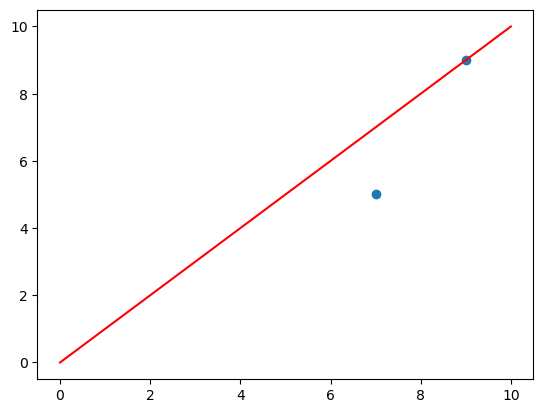

In [23]:
x = [7, 9]
y = [5, 9]
plt.scatter(x, y)
plt.plot([0, 10], [0, 10], c="r")
plt.show()
# un point sur la ligne ça veut dire que la différence entre la prédiction et la vérité est de 0
# plus on s'éloigne de la ligne plus l'erreur est grande

### Linear model

#### Linear regression

In [19]:
print("Base train data :")
Kfold_pipeline(LinearRegression, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(LinearRegression, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(LinearRegression, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

Base train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.30901687258498745
RMSE:  16.8380323132355
CORR:  0.5558928608298248
PVAL:  0.0
MAX_ER:  261.3407863674734
MEAN_ABS_ER:  7.338182392289766
MEDIAN_ABS_ER:  3.8258231429359855

Radius results
RVE:  0.9873685426795851
RMSE:  0.11206128690888313
CORR:  0.9936642001601584
PVAL:  0.0
MAX_ER:  0.6588808734804303
MEAN_ABS_ER:  0.08048427077094716
MEDIAN_ABS_ER:  0.05786574271786071

No massive stars train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.5878738610825109
RMSE:  3.2329467773422427
CORR:  0.7667293271441844
PVAL:  0.0
MAX_ER:  21.0975678781259
MEAN_ABS_ER:  1.9929938203460211
MEDIAN_ABS_ER:  1.1574677953336268

Radius results
RVE:  0.9906064628081043
RMSE:  0.09825720028390682
CORR:  0.995292149475815
PVAL:  0.0
MAX_ER:  0.5481369718179769
MEAN_ABS_ER:  0.07538333570188122
MEDIAN_ABS_ER:  0.06126458082042452

PCA train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.30901687258498745
RMSE:  16.838

#### Ridge

In [20]:
print("Base train data :")
Kfold_pipeline(Ridge, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(Ridge, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(Ridge, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

Base train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.3090168726744542
RMSE:  16.838032312145423
CORR:  0.5558928608350088
PVAL:  0.0
MAX_ER:  261.3410094433782
MEAN_ABS_ER:  7.33817615630384
MEDIAN_ABS_ER:  3.825916383563096

Radius results
RVE:  0.9873685426773078
RMSE:  0.11206128691898451
CORR:  0.9936642001595697
PVAL:  0.0
MAX_ER:  0.6588639674529204
MEAN_ABS_ER:  0.08048433522428679
MEDIAN_ABS_ER:  0.057865452478165436

No massive stars train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.5878738610661661
RMSE:  3.232946777406351
CORR:  0.7667293271201954
PVAL:  0.0
MAX_ER:  21.097526006072854
MEAN_ABS_ER:  1.99299260741496
MEDIAN_ABS_ER:  1.1574634515708317

Radius results
RVE:  0.9906064628035638
RMSE:  0.09825720030765356
CORR:  0.9952921494738379
PVAL:  0.0
MAX_ER:  0.5481215560886581
MEAN_ABS_ER:  0.07538338828372189
MEDIAN_ABS_ER:  0.06126440051464965

PCA train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.3090168726744541
RMSE:  16.8380

### Decision tree regressor

In [19]:
print("Base train data :")
Kfold_pipeline(DecisionTreeRegressor, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(DecisionTreeRegressor, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(DecisionTreeRegressor, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

Base train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9952023032877289
RMSE:  1.4030538256557983
CORR:  0.9976009713782806
PVAL:  0.0
MAX_ER:  174.61712840313982
MEAN_ABS_ER:  0.1316644575386716
MEDIAN_ABS_ER:  0.005560744585888733

Radius results
RVE:  0.9998066679763675
RMSE:  0.013863856319125518
CORR:  0.9999033629467465
PVAL:  0.0
MAX_ER:  1.494991900608426
MEAN_ABS_ER:  0.007197271326822819
MEDIAN_ABS_ER:  0.003572606547596946

No massive stars train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9990882484585348
RMSE:  0.15206341480925273
CORR:  0.9995442098286803
PVAL:  0.0
MAX_ER:  12.53082985523568
MEAN_ABS_ER:  0.038311567651091345
MEDIAN_ABS_ER:  0.005145648663500868

Radius results
RVE:  0.9998222381857724
RMSE:  0.013516830092059194
CORR:  0.9999111541477291
PVAL:  0.0
MAX_ER:  0.5434143734501703
MEAN_ABS_ER:  0.007075631052745678
MEDIAN_ABS_ER:  0.0034908005098561734

PCA train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9922772120145

### KNeighbours regressor

In [22]:
print("Base train data :")
Kfold_pipeline(KNeighborsRegressor, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(KNeighborsRegressor, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(KNeighborsRegressor, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

Base train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9904188428896745
RMSE:  1.9829586546549516
CORR:  0.9952988059235017
PVAL:  0.0
MAX_ER:  127.52316531624923
MEAN_ABS_ER:  0.2050427800469664
MEDIAN_ABS_ER:  0.014054413316233805

Radius results
RVE:  0.9998512268588733
RMSE:  0.01216212763195574
CORR:  0.9999256230051184
PVAL:  0.0
MAX_ER:  0.29422562882024184
MEAN_ABS_ER:  0.0064465970936949234
MEDIAN_ABS_ER:  0.0031030665525847434

No massive stars train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.998783097287211
RMSE:  0.17568803950992923
CORR:  0.9993955642872521
PVAL:  0.0
MAX_ER:  7.384421706285128
MEAN_ABS_ER:  0.05793626575067556
MEDIAN_ABS_ER:  0.01299250300220578

Radius results
RVE:  0.9998599453942056
RMSE:  0.011998659563343015
CORR:  0.9999299835306721
PVAL:  0.0
MAX_ER:  0.28009615436979773
MEAN_ABS_ER:  0.006372800141763392
MEDIAN_ABS_ER:  0.0030691694744557907

PCA train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.990418870534

### Support vector regressor

In [23]:
print("Base train data :")
Kfold_pipeline(SVR, x_train_data=X_TRAIN, y_train_data=y_TRAIN)

Base train data :
split 1 

ValueError: y should be a 1d array, got an array of shape (786574, 2) instead.

### Random forest regressor

In [ ]:
# très long donc je teste juste sur 1 pour l'instant
# Kfold_pipeline(RandomForestRegressor)
print("Base train data :")
Kfold_pipeline(RandomForestRegressor, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(RandomForestRegressor, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(RandomForestRegressor, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

split 1


KeyboardInterrupt: 

In [69]:
kf = KFold(n_splits=10, shuffle=True, random_state=12)
TRUTH_MASS=None
TRUTH_RADIUS=None
PREDS_MASS=None
PREDS_RADIUS=None
counter = 0
print("split", end=' ')
for train_index, test_index in kf.split(X_TRAIN):
    counter += 1
    print(str(counter), end=' ')
    X_train, X_test = X_TRAIN[train_index], X_TRAIN[test_index]
    y_train, y_test = y_TRAIN[train_index], y_TRAIN[test_index]

    mdl = RandomForestRegressor()
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)

    if TRUTH_MASS is None:
        PREDS_MASS=preds[:, 0]
        TRUTH_MASS=y_test[:, 0]
    else:
        PREDS_MASS=np.hstack((PREDS_MASS, preds[:, 0]))
        TRUTH_MASS=np.hstack((TRUTH_MASS, y_test[:, 0]))

    if TRUTH_RADIUS is None:
        PREDS_RADIUS=preds[:, 1]
        TRUTH_RADIUS=y_test[:, 1]
    else:
        PREDS_RADIUS=np.hstack((PREDS_RADIUS, preds[:, 1]))
        TRUTH_RADIUS=np.hstack((TRUTH_RADIUS, y_test[:, 1]))
    break

print()
print("Mass results:")
print("RVE: ",explained_variance_score(TRUTH_MASS, PREDS_MASS))
print("RMSE: ",root_mean_squared_error(TRUTH_MASS, PREDS_MASS))
corr, pval=pearsonr(TRUTH_MASS, PREDS_MASS)
print("CORR: ",corr)
print("PVAL: ",pval)
print("MAX_ER: ",max_error(TRUTH_MASS, PREDS_MASS))
print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_MASS, PREDS_MASS))  
print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_MASS, PREDS_MASS))

print()
print("Radius results")
print("RVE: ",explained_variance_score(TRUTH_RADIUS, PREDS_RADIUS))
print("RMSE: ",root_mean_squared_error(TRUTH_RADIUS, PREDS_RADIUS))
corr, pval=pearsonr(TRUTH_RADIUS, PREDS_RADIUS)
print("CORR: ",corr)
print("PVAL: ",pval)
print("MAX_ER: ",max_error(TRUTH_RADIUS, PREDS_RADIUS))
print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))  
print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))

split 1 
Mass results:
RVE:  0.9979971612522945
RMSE:  0.8897723222979466
CORR:  0.9989990388735349
PVAL:  0.0
MAX_ER:  95.13832901219004
MEAN_ABS_ER:  0.09816245592922257
MEDIAN_ABS_ER:  0.007945579678619863

Radius results
RVE:  0.9999162533559964
RMSE:  0.009111516631795574
CORR:  0.9999581343850581
PVAL:  0.0
MAX_ER:  0.17793452382785047
MEAN_ABS_ER:  0.004513832099154549
MEDIAN_ABS_ER:  0.001878066205547424


### Adaboost regressor

In [ ]:
Kfold_pipeline(AdaBoostRegressor)

split 1 

ValueError: y should be a 1d array, got an array of shape (786574, 2) instead.

### XGB regressor

In [24]:
print("Base train data :")
Kfold_pipeline(XGBRegressor, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(XGBRegressor, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(XGBRegressor, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

Base train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9928464903002319
RMSE:  1.7132360835078733
CORR:  0.9964180011819096
PVAL:  0.0
MAX_ER:  110.18805938646284
MEAN_ABS_ER:  0.39463116689494715
MEDIAN_ABS_ER:  0.10416346884673477

Radius results
RVE:  0.9994233045747828
RMSE:  0.02394430071401917
CORR:  0.9997116187617062
PVAL:  0.0
MAX_ER:  0.5126239784743876
MEAN_ABS_ER:  0.015282643275083125
MEDIAN_ABS_ER:  0.011229646007128169

No massive stars train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9976024472038579
RMSE:  0.24658551889858976
CORR:  0.998800526603412
PVAL:  0.0
MAX_ER:  6.6038831100335535
MEAN_ABS_ER:  0.12457318504025987
MEDIAN_ABS_ER:  0.06460424986924651

Radius results
RVE:  0.999515025535636
RMSE:  0.022325913737647533
CORR:  0.9997574861030442
PVAL:  0.0
MAX_ER:  0.5735360958383472
MEAN_ABS_ER:  0.014035917675008317
MEDIAN_ABS_ER:  0.010257264828907209

PCA train data :
split 1 2 3 4 5 6 7 8 9 10 
Mass results:
RVE:  0.9883668463419616


### MLP regressor

In [ ]:
# Trééééés long, 30 minutes pour 1 split
print("Base train data :")
Kfold_pipeline(MLPRegressor, x_train_data=X_TRAIN, y_train_data=y_TRAIN)
print("\nNo massive stars train data :")
Kfold_pipeline(MLPRegressor, x_train_data=X_TRAIN_mass, y_train_data=y_TRAIN_mass)
print("\nPCA train data :")
Kfold_pipeline(MLPRegressor, x_train_data=X_TRAIN_PCA, y_train_data=y_TRAIN)

Base train data :
split 1 

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2 

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3 

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


4 

In [71]:
kf = KFold(n_splits=10, shuffle=True, random_state=12)
TRUTH_MASS=None
TRUTH_RADIUS=None
PREDS_MASS=None
PREDS_RADIUS=None
counter = 0
print("split", end=' ')
for train_index, test_index in kf.split(X_TRAIN):
    counter += 1
    print(str(counter), end=' ')
    X_train, X_test = X_TRAIN[train_index], X_TRAIN[test_index]
    y_train, y_test = y_TRAIN[train_index], y_TRAIN[test_index]

    mdl = MLPRegressor()
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)

    if TRUTH_MASS is None:
        PREDS_MASS=preds[:, 0]
        TRUTH_MASS=y_test[:, 0]
    else:
        PREDS_MASS=np.hstack((PREDS_MASS, preds[:, 0]))
        TRUTH_MASS=np.hstack((TRUTH_MASS, y_test[:, 0]))

    if TRUTH_RADIUS is None:
        PREDS_RADIUS=preds[:, 1]
        TRUTH_RADIUS=y_test[:, 1]
    else:
        PREDS_RADIUS=np.hstack((PREDS_RADIUS, preds[:, 1]))
        TRUTH_RADIUS=np.hstack((TRUTH_RADIUS, y_test[:, 1]))
    break

print()
print("Mass results:")
print("RVE: ",explained_variance_score(TRUTH_MASS, PREDS_MASS))
print("RMSE: ",root_mean_squared_error(TRUTH_MASS, PREDS_MASS))
corr, pval=pearsonr(TRUTH_MASS, PREDS_MASS)
print("CORR: ",corr)
print("PVAL: ",pval)
print("MAX_ER: ",max_error(TRUTH_MASS, PREDS_MASS))
print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_MASS, PREDS_MASS))  
print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_MASS, PREDS_MASS))

print()
print("Radius results")
print("RVE: ",explained_variance_score(TRUTH_RADIUS, PREDS_RADIUS))
print("RMSE: ",root_mean_squared_error(TRUTH_RADIUS, PREDS_RADIUS))
corr, pval=pearsonr(TRUTH_RADIUS, PREDS_RADIUS)
print("CORR: ",corr)
print("PVAL: ",pval)
print("MAX_ER: ",max_error(TRUTH_RADIUS, PREDS_RADIUS))
print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))  
print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))

split 1 
Mass results:
RVE:  0.948873047121406
RMSE:  4.507970784338664
CORR:  0.9743212793829307
PVAL:  0.0
MAX_ER:  126.20152720121959
MEAN_ABS_ER:  1.7504682057433405
MEDIAN_ABS_ER:  0.7501270477934466

Radius results
RVE:  0.996909595709774
RMSE:  0.055344822615252975
CORR:  0.9984587829256812
PVAL:  0.0
MAX_ER:  0.5171337636424453
MEAN_ABS_ER:  0.035280193009108556
MEDIAN_ABS_ER:  0.022433301737730837


c:\Users\antoi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Parameter tuning

In [19]:
print(y_IVS)

[[ 0.34542254 -0.51293473]
 [ 0.69656751  1.70131578]
 [ 1.0497905   2.35969294]
 ...
 [ 2.29980154  2.2158493 ]
 [24.64651516  1.43565778]
 [ 0.73709532 -0.19643211]]


In [16]:
# Define the Optuna objective function
def objective(trial):
    # Hyperparameters to tune
    param = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    # Train the XGBoost Classifier
    mdl = XGBRegressor(**param)
    mdl.fit(x_train, y_train, verbose=False)
    
    # Predict on validation set
    y_val_pred = mdl.predict(x_val)
    val_f1 = root_mean_squared_error(y_val, y_val_pred)
    
    return val_f1

x_train, x_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.25, random_state=1337)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best parameters
mdl = XGBRegressor(
    **best_params
)
mdl.fit(X_TRAIN, y_TRAIN)

# Evaluate on test set
y_IVS_pred = mdl.predict(X_IVS)
TRUTH_MASS, PREDS_MASS = y_IVS[:, 0], y_IVS_pred[:, 0]
TRUTH_RADIUS, PREDS_RADIUS = y_IVS[:, 1], y_IVS_pred[:, 1]

print()
print("Mass results:")
print("RVE: ",explained_variance_score(TRUTH_MASS, PREDS_MASS))
print("RMSE: ",root_mean_squared_error(TRUTH_MASS, PREDS_MASS))
corr, pval=pearsonr(TRUTH_MASS, PREDS_MASS)
print("CORR: ",corr)
print("PVAL: ",pval)
print("MAX_ER: ",max_error(TRUTH_MASS, PREDS_MASS))
print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_MASS, PREDS_MASS))  
print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_MASS, PREDS_MASS))

print()
print("Radius results")
print("RVE: ",explained_variance_score(TRUTH_RADIUS, PREDS_RADIUS))
print("RMSE: ",root_mean_squared_error(TRUTH_RADIUS, PREDS_RADIUS))
corr, pval=pearsonr(TRUTH_RADIUS, PREDS_RADIUS)
print("CORR: ",corr)
print("PVAL: ",pval)
print("MAX_ER: ",max_error(TRUTH_RADIUS, PREDS_RADIUS))
print("MEAN_ABS_ER: ",mean_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))  
print("MEDIAN_ABS_ER: ",median_absolute_error(TRUTH_RADIUS, PREDS_RADIUS))

[I 2025-04-14 12:02:00,674] A new study created in memory with name: no-name-8a698638-3515-4ddb-8450-42f764bf8df0
[I 2025-04-14 12:02:07,353] Trial 0 finished with value: 1.6683374777624462 and parameters: {'max_depth': 6, 'learning_rate': 0.16910650917965592, 'n_estimators': 279, 'subsample': 0.6622961093920944, 'colsample_bytree': 0.545594345225553}. Best is trial 0 with value: 1.6683374777624462.
[I 2025-04-14 12:02:14,904] Trial 1 finished with value: 0.8325075789837557 and parameters: {'max_depth': 7, 'learning_rate': 0.2490106674082993, 'n_estimators': 293, 'subsample': 0.6228556841215048, 'colsample_bytree': 0.9726123657529926}. Best is trial 1 with value: 0.8325075789837557.
[I 2025-04-14 12:02:22,985] Trial 2 finished with value: 1.779351307733612 and parameters: {'max_depth': 8, 'learning_rate': 0.08912715713673781, 'n_estimators': 249, 'subsample': 0.5403171912579843, 'colsample_bytree': 0.6454152051957318}. Best is trial 1 with value: 0.8325075789837557.
[I 2025-04-14 12:02

Best Hyperparameters: {'max_depth': 9, 'learning_rate': 0.2873466583441108, 'n_estimators': 299, 'subsample': 0.9167588091230283, 'colsample_bytree': 0.9647501664663177}

Mass results:
RVE:  0.995373961798925
RMSE:  1.3820548936594947
CORR:  0.9976848370268526
PVAL:  0.0
MAX_ER:  76.18756933604101
MEAN_ABS_ER:  0.2684070919354524
MEDIAN_ABS_ER:  0.06796217695164031

Radius results
RVE:  0.9995551792694726
RMSE:  0.020993448456426665
CORR:  0.9997775658069714
PVAL:  0.0
MAX_ER:  0.5878789521238986
MEAN_ABS_ER:  0.011751070767294395
MEDIAN_ABS_ER:  0.007801378715809548


## Final model

In [21]:
mdl = XGBRegressor(max_depth=9, learning_rate=0.29756705156191526, n_estimators=252, subsample=0.8981926120724242, colsample_bytree=0.8552677784958321)
mdl.fit(X, y)

joblib.dump(mdl, 'model/primary_XGB.pkl')

['model/primary_XGB.pkl']

In [31]:
print(X_IVS[0])
print(X_IVS[0].reshape(1, -1))

[ 9.2         3.61857271  5.00232111 -2.        ]
[[ 9.2         3.61857271  5.00232111 -2.        ]]


In [28]:
test = mdl.predict([[ 9.2, 3.61857271, 5.00232111, -2.]])
print(test)

[[ 0.33749375 -0.49359918]]


In [30]:
test = mdl.predict(X_IVS[0].reshape(1, -1))
print(test)

[[ 0.33749375 -0.49359918]]


In [33]:
star_mass1, log_R1 = mdl.predict(X_IVS[0].reshape(1, -1)).flatten()
print(star_mass1, log_R1)

0.33749375 -0.49359918
